In [1]:
import pandas as pd
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from selenium import webdriver
import os
import time
import sys
from bs4 import BeautifulSoup

# 긍정, 부정 학습

In [2]:
from eunjeon import Mecab

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x26e0b865f70>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data))

전체 리뷰 개수 : 200000


In [5]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [6]:
#중복을 제외한 샘플의 수
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [7]:
#훈련용 데이터와 테스트용 데이터를 나눔
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


In [8]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


<ipython-input-8-5c91c21161d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\wlsrh\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [9]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


<ipython-input-9-5968a3f5f2bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
<ipython-input-9-5968a3f5f2bc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [10]:
#train, test 데이터에 Mecab을 사용하여 토큰화 작업 중 '의', '이' 등 필요없는 토큰 삭제
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [11]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

<ipython-input-11-2ccd7617a3d9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
<ipython-input-11-2ccd7617a3d9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])


In [12]:
#긍정과 부정 단어들을 저장하는 리스트 생성
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [13]:
#부정적인 단어들 중 빈도수가 높은 상위 20개 단어 출력
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31823), ('는데', 20095), ('안', 19748), ('어요', 14869), ('있', 13200), ('너무', 13056), ('했', 11796), ('좋', 9797), ('배송', 9623), ('같', 8995), ('거', 8904), ('어', 8896), ('구매', 8884), ('없', 8695), ('아요', 8636), ('습니다', 8436), ('그냥', 8353), ('되', 8350), ('잘', 8029), ('않', 7986)]


In [14]:
#긍정적인 단어들 중 빈도수가 높은 상위 20개 단어 출력
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39365), ('아요', 21151), ('네요', 19906), ('어요', 18672), ('잘', 18612), ('구매', 16175), ('습니다', 13322), ('있', 12380), ('배송', 12263), ('는데', 11579), ('합니다', 9850), ('했', 9806), ('먹', 9453), ('재', 9252), ('너무', 8398), ('같', 7867), ('만족', 7225), ('거', 6485), ('기', 6341), ('어', 6317)]


In [15]:
#train, test set에 저장
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [16]:
#기계가 텍스트를 숫자로 처리할 수 있도록 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [17]:
#등장 횟수가 1인 단어들 배제하기 위해 단어들의 비중 검색
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39741
등장 빈도가 1번 이하인 희귀 단어의 수: 18056
단어 집합에서 희귀 단어의 비율: 45.43418635665937
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7869324583053495


In [18]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21687


In [19]:
#텍스트를 숫자로 변환
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
print(X_train[:3])
print(X_test[:3])

[[67, 2067, 301, 14197, 261, 73, 6, 238, 170, 135, 807, 2939, 624, 2, 76, 62, 206, 40, 1356, 155, 3, 6], [479, 405, 53, 8473, 2597, 2373, 338, 2940, 248, 2387, 39, 472, 2], [44, 24, 817, 103, 35, 2374, 160, 7, 10, 8007, 4, 1326, 30, 139, 321, 45, 59, 160, 139, 7, 1935, 2, 113, 161, 1388, 302, 120, 134]]
[[14, 711, 772, 118, 186, 249, 12], [338, 3902, 62, 3817, 1607], [11, 70, 2, 49, 165, 3, 27, 15, 6, 513, 289, 17, 93, 110, 585, 59, 7, 2]]


In [20]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.303566307167964


In [21]:
#길이가 80이하인 샘플을 제외하고 삭제
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 80
below_threshold_len(max_len, X_train)
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [22]:
#GRU를 이용하여 감성 분석(데이터를 학습시킴)
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2731 - acc: 0.8984
Epoch 00001: val_acc improved from -inf to 0.91826, saving model to best_model.h5
2000/2000 [==============================] - 137s 68ms/step - loss: 0.2731 - acc: 0.8984 - val_loss: 0.2254 - val_acc: 0.9183
Epoch 2/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.2135 - acc: 0.9233
Epoch 00002: val_acc improved from 0.91826 to 0.92323, saving model to best_model.h5
2000/2000 [==============================] - 135s 67ms/step - loss: 0.2135 - acc: 0.9233 - val_loss: 0.2123 - val_acc: 0.9232
Epoch 3/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1978 - acc: 0.9296- ETA: 1s - 
Epoch 00003: val_acc improved from 0.92323 to 0.92710, saving model to best_model.h5
2000/2000 [==============================] - 139s 70ms/step - loss: 0.1978 - acc: 0.9296 - val_loss: 0.2047 - val_acc: 0.9271
Epoch 4/15
1999/2000 [============================>.] - ETA: 0s - loss: 0.1875 

In [23]:
#테스트 정확도 출력
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 18s 12ms/step - loss: 0.2127 - acc: 0.9251

 테스트 정확도: 0.9251


# 크롤링

In [271]:
search=input('검색어를 입력하세요: ')
url="https://www.musinsa.com/"

검색어를 입력하세요: 이벳필드


In [272]:
browser=webdriver.Chrome(executable_path="chromedriver.exe") #chromedriver 실행-윈도우
#browser = webdriver.Chrome('/Users/malangcongdduck/Downloads/chromedriver')#chromedriver 실행-맥
browser.get(url) #검색

In [273]:
#소스코드가 있는 경로에 '검색어' 폴더가 없으면 만들어준다
if not os.path.exists(search):
    os.mkdir(search)

In [274]:
search_box = browser.find_element_by_xpath('//*[@class="search head-search-inp keyword-dec"]') #검색창 
search_box.send_keys(search)
time.sleep(1)

In [275]:
# 전체 소스 가져오기
full_html = browser.page_source
soup = BeautifulSoup(full_html, 'html.parser')

In [276]:
brand_recommend=[] #추천 상품리스트의 브랜드명 리스트
item_recommend=[] #추천 상품리스트의 상품명 리스트
recommend_list = soup.find_all('dd', class_='recommendProduct listItem ui-good-listiem clearfix') #추천 리스트 전체 가져오기

for item in recommend_list:
    brand_name=item.find('p', class_='brand').text
    item_name=item.find('p', class_='product ellipsis').text
    brand_recommend.append(brand_name)
    item_recommend.append(item_name)
    


In [277]:
#데이터 프레임 생성
recommend_df = pd.DataFrame([ x for x in zip(brand_recommend,item_recommend)])
recommend_df.columns=['브랜드','상품명']
print(recommend_df)

#원하는 상품 선택해서 검색
search_num=int(input('원하는 상품의 번호를 입력하세요: '))
browser.find_element_by_xpath('//*[@class="recommendProduct-list list"]/dd['+str(search_num+1)+']/div/a').click()
time.sleep(2)

      브랜드                                             상품명
0  [이벳필드]                                EFF 베츠 반팔 티셔츠 블루
1  [이벳필드]              EBFD 에코 코튼 2-PACK 베츠 기본 티셔츠 블랙/화이트
2  [이벳필드]                                EFF 베츠 반팔 티셔츠 블랙
3  [이벳필드]                               EFF 베츠 반팔 티셔츠 화이트
4  [이벳필드]                               EFF 베츠 반팔 티셔츠 네이비
5  [이벳필드]                                  EFF 베츠 맨투맨 그레이
6  [이벳필드]                            EBFD 아치로고 반팔 티셔츠 화이트
7  [이벳필드]    New York Black Yankees 1936 COTTON CAP BLACK
8  [이벳필드]                               EFF 베츠 반팔 티셔츠 딥블루
9  [이벳필드]                            EFF 베츠 스트라이프 롱슬리브 블랙
원하는 상품의 번호를 입력하세요: 0


In [278]:
#상세 페이지 소스 가져오기
full_html = browser.page_source
soup = BeautifulSoup(full_html, 'html.parser')

In [279]:
result_name=soup.find('span', class_='product_title').find('em').text
item_image=soup.find('div', class_='product-img').find('img') #상품명
image_src=item_image['src']
image_src=image_src.replace('//', 'https://')
urlretrieve( image_src , f'{search}/{result_name}.jpg')

('이벳필드/EFF 베츠 반팔 티셔츠 블루.jpg', <http.client.HTTPMessage at 0x26e2728a310>)

In [280]:
category=soup.find('p', class_='item_categories').text
category=category.split()
category_name=category[0]
detail_category_name=category[2]
brand_name=category[3]
brand_name=brand_name.replace("(","")
brand_name=brand_name.replace(")","")

#print(category_name, detail_category_name, brand_name)

상의 반팔 티셔츠


In [281]:
category_review=[]

#리뷰 종류
estimate_style = soup.find('span', id='estimate_style')
estimate_photo = soup.find('span', id='estimate_photo')
estimate_goods = soup.find('span', id='estimate_goods')

# 여러자리 숫자 단위를 category_name에서 리뷰개수 추출
category_review.append(re.findall("\d+", str(estimate_style)))
category_review.append(re.findall("\d+", str(estimate_photo)))
category_review.append(re.findall("\d+", str(estimate_goods)))

for i in category_review:
    if len(i) != 1:
        i[0]=i[0]+i[1]
        del i[1]
        
print(category_review)
category_review = sum(category_review, [])
category_review = list(map(int,category_review))
print(category_review)


[['215'], ['311'], ['904']]
[215, 311, 904]


In [282]:
# 전체 소스 가져오기
full_html = browser.current_url
full_html = full_html.split('/')

#상품번호와 리뷰 페이지이름
product = full_html[-1]
print(product)

1846930


In [283]:
score_style=[]
text_style=[]
count = 0
page=1 #2
review_index = 0

#스타일 후기 리뷰 크롤링
review_page = 'style'
browser.find_element_by_xpath('//*[@class="snb"]/li['+str(1)+']/h4/span').click()
page_num=browser.find_element_by_xpath("//div[@class='wrap review_list_detail style_review']/div/div[@class='nslist_bottom']/div").text
page_num = re.findall("\d+", page_num)
page_num = list(map(int,page_num)) #page_num[0]은 마지막 페이지를 나타냄
page = page_num[1]
end_page = page_num[0]

while(True):
    print(page, end_page)
    time.sleep(3) 
    content_list_style = browser.find_elements_by_css_selector('div.wrap.review_list_detail.style_review > div.galleryList.gallery_store.review-wrap > div.nslist_post.area-gallery-post.review-list') #스타일후기
    
    for i in range(1, len(content_list_style)+1):
        count+=1
        
        #각 요소 가져오기
        tmp_score_tag = browser.find_element_by_xpath("//div[@class='wrap review_list_detail style_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='review-size']/div")
        tmp_name = tmp_score_tag.get_attribute('innerHTML') #태그의 클래스 이름 가져오기
        tmp_score = re.findall("\d+", tmp_name)
        tmp_score = int(tmp_score[0])
        #print(tmp_score)

        tmp_text = browser.find_element_by_xpath("//div[@class='wrap review_list_detail style_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='pContent']") #태그
        tmp_text = tmp_text.text
        #print(tmp_text)
        
        score_style.append(tmp_score)
        text_style.append(tmp_text)

        print(f"총 {category_review[review_index]} 건 중 {count} 번째 리뷰 데이터를 수집합니다====================================")
        print('1) 별점:', tmp_score)
        print('2) 리뷰내용:', tmp_text)
        print('\n')

        # 만약 현재 글 수가 입력건수에 도달하면 루프 종료
        if(count == category_review[review_index]):
            break

    if(count == category_review[review_index]):
        break

    # 아직 입력건수에 도달하지 않았다면 다음 페이지를 열고 루프 계속
    else:
        page=page+1
        if page > end_page:
            print('삭제된 리뷰를 제외한 모든 리뷰를 가져왔습니다.')
            break
        browser.execute_script(f'viewEstimateByPage("{product}","0","{page}","{review_page}","","","N","new")')
        browser.implicitly_wait(5)

1 22
총 215 건 중 1 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 약간 오버핏이었어요 기장도 좀 길어서 평소 L입는데 M도 넉넉하네요~~


총 215 건 중 2 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 완전 편하게 입을 수 있는 반팔티에요. 소재가 다른 것 보다 얇은 것 같아요.


총 215 건 중 3 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 길이감도 오버핏이라 맘에 들고 프린팅이 넘 맘에 드네요 청바지에 이쁘게 코디 가능합니다


총 215 건 중 4 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 쿠폰우로 싸게 잘 샀어요 ㅋㅋ 티셔츠가 귀엽네요 잘 입어야겠어요


총 215 건 중 5 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 진짜 근본이되는 티셔츠입니다
생각보다 사이즈가 크네요????


총 215 건 중 6 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 로고도 귀엽고 사이즈도 적당합니다 잘입을께요


총 215 건 중 7 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 편하게 입고 다니기에도 좋고, 귀여운 옷이라 좋아요


총 215 건 중 8 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 로고가 너무 귀여워서 구매햇어요 커플티로 아주 좋아요


총 215 건 중 9 번째 리뷰 데이

총 215 건 중 65 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 이쁘네요 ㅎㅎ 로고플레이하기 좋고 간단하게 입기 좋습니다


총 215 건 중 66 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 너무너무 예뻐요. 잘 산거 같아서 기분이 좋아요. 앞으로 잘 입고 다니겠습니다


총 215 건 중 67 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 프린팅 귀엽고 여름에 유용하게 입을것 같네요!! 좋습니다


총 215 건 중 68 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이쁘거 귀여움 편하고 얇아서 여름에 자주 입을 거 같아요


총 215 건 중 69 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 전체적으로 사이즈가 큰편이고 특히 어깨 부분이 많이 크네요 동생 사줬는데 되게 좋아하네요 60이 넘지 않은 분들은 s가도 넉넉하게 맞을거에요
동생 키는 59입니다


총 215 건 중 70 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 좋아요 깔끔하고 오버핏으로 입기 좋아요 레이어드도 할만함 굿굿


8 22
총 215 건 중 71 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 꾸러기룩으로 샀습니다 품은좋은데 팔이 좀 기네요


총 215 건 중 72 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 사이즈가 조금 클줄

총 215 건 중 130 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 옷이 조금 크긴 한데 가운데 있는 캐릭터 디자인이 너무 귀여워요 시원해 보이기도 하네요


14 22
총 215 건 중 131 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 사이즈 적당하고 딱 떨어지는게 핏 만족합니다
기장감 넣어서 입는게 좋아요


총 215 건 중 132 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 운동복 위에 입으려고 구입했어요~ 길이도 엉덩이 덮고 딱 좋네요!


총 215 건 중 133 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 나름 괜찮은 반팔티입니다
색감도 시원시원하고 재질도 좋아요


총 215 건 중 134 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 제 키에 조금 길긴 한데 바지에 넣어서 입으면 너무 예뻐용❣️


총 215 건 중 135 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 여자친구랑 커플티 했어용 싸고 배송 빠르고 너무 좋네용


총 215 건 중 136 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 배송도 옴청 빠르고 좋네요 여름에 아무때나 입으면 될 고 같습니다.


총 215 건 중 137 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 반팔치곤 두께감 살짝 있는데 화이트라서 이정도 두께감

In [284]:
score_photo=[]
text_photo=[]
count = 0
page=1 #2
review_index = 1

#상품 사진 후기 리뷰 크롤링
review_page = 'photo'
browser.find_element_by_xpath('//*[@class="snb"]/li['+str(2)+']/h4/span').click()
page_num=browser.find_element_by_xpath("//div[@class='wrap review_list_detail photo_review']/div/div[@class='nslist_bottom']/div").text
page_num = re.findall("\d+", page_num)
page_num = list(map(int,page_num)) #page_num[0]은 마지막 페이지를 나타냄
page = page_num[1]
end_page = page_num[0]

while(True):
    time.sleep(5) 
    content_list_photo = browser.find_elements_by_css_selector('div.wrap.review_list_detail.photo_review > div.galleryList.gallery_store.review-wrap > div.nslist_post.area-gallery-post.review-list') #스타일후기
    
    for i in range(1, len(content_list_photo)+1):
        count+=1
        
        #각 요소 가져오기
        tmp_score_tag = browser.find_element_by_xpath("//div[@class='wrap review_list_detail photo_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='review-size']/div")
        tmp_name = tmp_score_tag.get_attribute('innerHTML') #태그의 클래스 이름 가져오기
        tmp_score = re.findall("\d+", tmp_name)
        tmp_score = int(tmp_score[0])
        #print(tmp_score)

        tmp_text = browser.find_element_by_xpath("//div[@class='wrap review_list_detail photo_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='pContent']") #태그
        tmp_text = tmp_text.text
        #print(tmp_text)
        
        score_photo.append(tmp_score)
        text_photo.append(tmp_text)

        print(f"총 {category_review[review_index]} 건 중 {count} 번째 리뷰 데이터를 수집합니다====================================")
        print('1) 별점:', tmp_score)
        print('2) 리뷰내용:', tmp_text)
        print('\n')

        # 만약 현재 글 수가 입력건수에 도달하면 루프 종료
        if(count == category_review[review_index]):
            break

    if(count == category_review[review_index]):
        break

    # 아직 입력건수에 도달하지 않았다면 다음 페이지를 열고 루프 계속
    else:
        page=page+1
        if page > end_page:
            print('삭제된 리뷰를 제외한 모든 리뷰를 가져왔습니다.')
            break
        browser.execute_script(f'viewEstimateByPage("{product}","0","{page}","{review_page}","","","N","new")')
        browser.implicitly_wait(5)

총 311 건 중 1 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 팔소매길이 마음에 들어요
색은 예상보다 좀 밝은 것 같은데 예뻐요
두꺼운 소재는 아니지만 얇지않아서 튼튼해보여요


총 311 건 중 2 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 길이감도 오버핏이라 넣입하기도 좋고 프린팅도 귀여워서 넘 맘에 들어요 청바지 코디하기도 좋습니다


총 311 건 중 3 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 좋습니다. 가성비도 좋고 재구매의사 있습니다. 추천


총 311 건 중 4 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: L사이즈가 조금커서 M아이즈로 교환하려다가 살짝오버핏으로입고다녀도이쁠것같아서 교환안하고 이쁘게입겠습니다~^^


총 311 건 중 5 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 정사이즈핏으러 입으려고 M했는데 딱 내스펙에 정사이즈임 오버핏원하면 1사이즈 업 강추! 다른티에비해 얇은재질임 , 딱 색깔차이만봐도 티가남


총 311 건 중 6 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 쿠폰우로 싸게 잘 샀어요 ㅋㅋ 티셔츠가 귀엽네요 잘 입어야겠어요


총 311 건 중 7 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 스몰인데도 엄청 클까봐 걱정했는데 롤업하고 입으면 적당할거같아요! 오프라인에서 만져보고 산거라 재질도 좋아요! 역시 그림이 넘 귀여움 ㅜㅜ


총

총 311 건 중 67 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 정말이쁘고이쁘다그리고이쁘다이쁘고이쁘다


총 311 건 중 68 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 사이즈 괜찮은데 스티커가 잘떨어지네요 그게 조금 아쉽습니다


총 311 건 중 69 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 오버한 핏에 가운데 캐릭터로 포인트를 준게 예뻐요
청바지와 같이 입으니 잘 어울리고 좋아요


총 311 건 중 70 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 여름엔 반팔을 입어야한다면 전 이벳필드 상품중에서 고민할 것입니다.
입었을 때 부드럽고 편안한 옷이지요.
반값 세일 할 때 샀답니다.
우리 모두 예쁜 옷 쇼핑에 성공해보아요.
이상입니다.


총 311 건 중 71 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 품도 넉넉하고 두께감이 살짝 있어서 짱짱하고 퀄리티 좋습니다. 마음에 들어요!
첫번째는 착용샷 두번째는 상품이 보이는 사진입니다.


총 311 건 중 72 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 시원하게 프린팅된 귀여운 마리오아저씨 티셔츠


총 311 건 중 73 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 굉장히 무난하게 입고 있고요 심플하고 귀여워여


총 311 건 중 74 번째 리뷰 데이터를 수집합니다============================

총 311 건 중 131 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 짱 커 요 ! 워! 팔길이 무엇 팔 통 무엇 생각보다 훨씬 크ㅂ니다


총 311 건 중 132 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 진짜 완전 커요,, 흑흑 엠 할걸 그랬어요!!! 그래도 뭐 귀여운 맛으로 입겠습니다


총 311 건 중 133 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 제가 딱 원햇던 오버핏 느낌이고, 페인팅 이쁩니다. 추천!


총 311 건 중 134 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 예리가 입어서 샀는데 너무이뻐요 얇아서 여름에 아주 많이 입을거같아요


총 311 건 중 135 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 옷 너무 귀여워요 노란 모자
여름에 잘 입고 다닐 거 같아여


총 311 건 중 136 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 6
2) 리뷰내용: L 갔다가 생각보다 커서 M 갔는데 딱 적당한 오버핏이 됐어요


총 311 건 중 137 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 무난하게 교복이랑 입기 좋은것 같습니다 예뻐요


총 311 건 중 138 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 조금 먼지가 잘 붙는거 말고는 가성비 좋은 상품입니다


총 311 건 중 139 번째 



총 311 건 중 197 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 무난하고 깔끔합니다
비치는부분도 로고로 가려져서 좋은.. ㅎㅎ


총 311 건 중 198 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 원단짱짱..해요..
세탁후 목늘어짐..
벌써부터..걱정안할랍니다ㅎㅎ


총 311 건 중 199 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 잘받았습니다 사이즈도 딱 맞고 재질이 좋습니다여


총 311 건 중 200 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 귀엽네여 근데 좀 큰편이에요
하얀색이라 한철용이지만 포인트되서 좋아요


총 311 건 중 201 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 심플한 로고가 딱 좋습니다 청바지 반바지 어느곳에도 어울립니다! 무난하게 좋아용


총 311 건 중 202 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 실물이 더 이쁜듯 원래 오버핏인데 크게입으려고 미듐 시킴 엄청나게 큼 완전 만족


총 311 건 중 203 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 받아서 보니까 조금한 오염이 되어있네요 조금은 아쉽지만 세탁해서 입으면 되는거고 로고 색감도 이쁘고 하니 그냥 입겠습니다


총 311 건 중 204 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 6
2) 리뷰내용: 와 

In [285]:
score_goods=[]
text_goods=[]
count = 0
page=1 #2
review_index = 2

#일반 후기 리뷰 크롤링
review_page = 'goods'
browser.find_element_by_xpath('//*[@class="snb"]/li['+str(3)+']/h4/span').click()
page_num=browser.find_element_by_xpath("//div[@class='wrap review_list_detail estimate_review']/div/div[@class='nslist_bottom']/div").text
page_num = re.findall("\d+", page_num)
page_num = list(map(int,page_num)) #page_num[0]은 마지막 페이지를 나타냄
page = page_num[1]
end_page = page_num[0]

while(True):
    time.sleep(3) 
    content_list_goods = browser.find_elements_by_css_selector('div.wrap.review_list_detail.estimate_review > div.galleryList.gallery_store.review-wrap > div.nslist_post.area-gallery-post.review-list') #일반 후기
    
    for i in range(1, len(content_list_goods)+1):
        count+=1
        
        #각 요소 가져오기
        tmp_score_tag = browser.find_element_by_xpath("//div[@class='wrap review_list_detail estimate_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='review-size']/div")
        tmp_name = tmp_score_tag.get_attribute('innerHTML') #태그의 클래스 이름 가져오기
        tmp_score = re.findall("\d+", tmp_name)
        tmp_score = int(tmp_score[0])
        #print(tmp_score)

        tmp_text = browser.find_element_by_xpath("//div[@class='wrap review_list_detail estimate_review']/div/div["+(str(i))+"]/div[2]/div/div[@class='pContent']") #태그
        tmp_text = tmp_text.text
        #print(tmp_text)
        
        score_goods.append(tmp_score)
        text_goods.append(tmp_text)

        print(f"총 {category_review[review_index]} 건 중 {count} 번째 리뷰 데이터를 수집합니다====================================")
        print('1) 별점:', tmp_score)
        print('2) 리뷰내용:', tmp_text)
        print('\n')

        # 만약 현재 글 수가 입력건수에 도달하면 루프 종료
        if(count == category_review[review_index]):
            break

    if(count == category_review[review_index]):
        break

    # 아직 입력건수에 도달하지 않았다면 다음 페이지를 열고 루프 계속
    else:
        page=page+1
        if page > end_page:
            print('삭제된 리뷰를 제외한 모든 리뷰를 가져왔습니다.')
            break
        browser.execute_script(f'viewEstimateByPage("{product}","0","{page}","{review_page}","","","N","new")')
        browser.implicitly_wait(5)

총 904 건 중 1 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 대일리로 그냥 간편하게 입는게 매우 좋습니다 자주입을거같네요


총 904 건 중 2 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 세미 오버핏이고 생각보다 좀 클수도있어요 정사이즈 사시면 세미 오버핏으로 이쁘게 입을 수 잇엉요


총 904 건 중 3 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 옷이 좀 크게나온건지 원래 다른반팔은 100 L사이즈 입어요


총 904 건 중 4 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 남자친구 선물로 사줬는데 너무 잘 맞아요!
어깨가 넓은편이라 XL 사이즈가 괜찮은듯 합니다


총 904 건 중 5 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 와 이거 실물이 진짜 대박이고 옷 잘 맞네요 잘입을거같아요


총 904 건 중 6 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 완전 좋아요오오 !! 예쁘고 귀엽고 편하게 입을 수 있어요.


총 904 건 중 7 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: s로 주문했는데 저한테 딱 알맞습니다. 약간 오버느낌이라 부담없어요. 좀더 크게 오버느낌을 강하게 가져가실분들은 m하면 되구요. 아니고 적당하게 오버한 느낌 살리실 분들은 s도 괜찮습니다.


총 904 건 중 8 번째 리뷰 데이터를 수집합니다=========================

총 904 건 중 70 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 기본티로 여름에 시원하게 입을 때 예쁘게 입을 수 있어요


총 904 건 중 71 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 질도 나쁘지않고 괜찮은듯해요 자주입을것같음


총 904 건 중 72 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 여름에도 입기 좋은 두께에요 이쁘긴 한데 클론이 너무 많아요


총 904 건 중 73 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 라지 사이즈로 사서 많이 박시해요 그렇지만 이뻐요


총 904 건 중 74 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 6
2) 리뷰내용: 얘도 클론이 좀 많긴 함
프린팅 이쁜데 많이 빨면 목 늘어날듯


총 904 건 중 75 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 가격대비해서 금방 늘어나서 오래 못입을듯 옷은 이쁘고 좋습니다


총 904 건 중 76 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 컬러가 마음에 들어요 귀엽기도 하고 재질이 좋아요


총 904 건 중 77 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 남자친구랑 같이 맞췄는데 귀여워요. 커플티로 추천합니다.


총 904 건 중 78 번째 리뷰 데이터를 수집합니다=============================

총 904 건 중 136 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 정말 너무귀어워요ㅜㅜ 무조건 구매하세요 세상 귀욥


총 904 건 중 137 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 사이즈가 생각보다 커서 평소 입는 사이즈보다 하나 작게 사는게 좋을것 같네요.


총 904 건 중 138 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 저렴하게 쿠폰사용하여 잘산거 같아요
디자인도 이쁘네요


총 904 건 중 139 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 앞에 귀여운 프린팅이 예쁩니다.
생각보다 오버핏으로 나왔네요


총 904 건 중 140 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이쁘네요. 많은사람들이 사는거같아서 고민하다가 샀는데, 청바지, 반바지, 슬랙스, 트레이닝복바지 다 잘 어울려요. 강력하게 추천합니다!


총 904 건 중 141 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 파란색이 잘빠져서 색은 맘에 들어요 조큼 얇은감은 있지만 그닥 안비치는듯해요?


총 904 건 중 142 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이거 왜 다들 사는지 알듯 귀여우면서 싸보이지않아요


총 904 건 중 143 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 굿 사이즈도좋내요 키도커

총 904 건 중 201 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 크게 입으려고 M 샀는데 생각보다 너므 커서 S 사도 컸을거같아요 그래도 너무 이뻐요


총 904 건 중 202 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 커플티로 샀는데 남자친구 사이즈랑 딱 맞고 너무 좋아해요!


총 904 건 중 203 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이벳필드의 EFF 베츠 반팔 티셔츠 블루티셔츠는 편하고 자주 입고 싶은 옷입니다.
흔한 로고플레이에 질린다면 이 옷은 어떤가요?
단순한 텍스트 로고와 달리 마스코트 캐릭터가 그려져 있어 다른 브랜드와 달리 신선한 느낌입니다.
앞으로도 이벳필드를 많이 이용할 것 같습니다.
이상입니다.


총 904 건 중 204 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 옷 자체가 크게 나와서 그런가 오버 사이즈로 괜찮네요


총 904 건 중 205 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 빨리 더워지면 입어보고싶어요 디자인 맘에 드네요 ㅎㅎ


총 904 건 중 206 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 꽤 크고 싸게 잘 산거 같아요 이뻐요 귀여운 포인트도 있고


총 904 건 중 207 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 받자마자 프린트가 너무 귀여워서 너무 잘 샀다 했습니다!
사이즈도 넉넉합니다!


총 904 건

총 904 건 중 266 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 깔끔하게 입기 좋고 프린팅 색깔이 선명해서 이뻐요


총 904 건 중 267 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 재질 탄탄하고 좋아요 여름에 잘 입을 거 같습니다


총 904 건 중 268 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 귀여운 프린팅에 예뻐서 아주 잘 입을거 같숩니다


총 904 건 중 269 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 귀여운 프린팅에 예뻐서 아주 잘 입을거 같숩니다


총 904 건 중 270 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 프린팅 이쁘고요. 기장이 좀 길게 나온것 같아요 참고하세요


총 904 건 중 271 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 요즘에 흰 반팔티가 사고싶어서 찾아보다가 이벳필드를 보았는데 평점도 좋고 사람들이 많이 구매해서 사봤는데 만족이 되게 높은 의상 같아요 ❕


총 904 건 중 272 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 매치 잘 하시는 분은 엄청 예쁘게 잘 입으실거같아요


총 904 건 중 273 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 170cm인 저한텐 좀 큰데 오버핏으로 입기에 아주 좋은 것 같아요 무난하게 이쁘구요 어디

총 904 건 중 336 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 비침도 적고 프린팅이 너무 이뻐서 어느코디에든 다 잘어울립니다!!


총 904 건 중 337 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 아조씨가 너무 해맑아서 귀여움 색감도 귀여움 핏도 귀어움


총 904 건 중 338 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 요즘 날이 더워져서 반팔티 새로 샀는데 슬랙스에 넣입해서 입으니 예쁘네요 다들 코디 예쁘게 하세요


총 904 건 중 339 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 흰색인데도 안 비치고 그렇다고 두껍지도 않아서 여름내내 시원하게 입을 수 있을것같아요! 넘 만족합니당ㅎㅎ


총 904 건 중 340 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 여름에 입기 괜찮은 것 같아요
청바지에 가볍게 입기 최고인 듯


총 904 건 중 341 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이벳필드 처음 사보는데 만족합니다 귀엽고 이쁘네요 ㅎㅎ


총 904 건 중 342 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 배송 빠르고 무난한 기본 데일리 반팔로 괜찮은 것 같습니다


총 904 건 중 343 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 옷이 편하고해서 여름에 많이 입

총 904 건 중 405 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 오버핏으로 입는거 좋아하시는 분들은 사이즈
적극 추천 드립니다


총 904 건 중 406 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 프린팅 이뻐서 구매했는데 만족합니다 청바지랑 찰떡이네요


총 904 건 중 407 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 생각보다 컸어요 오버핏으로 입고싶으신분들만 사는거 추천드립니당


총 904 건 중 408 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 역시 이벳이네여 기본티 맘에들어여 잘입고 다닐것같아요. 목도 짱짱하고 괜찮습니다.


총 904 건 중 409 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 6
2) 리뷰내용: 앞에 로고가 이뻐용 그냥 밖에다닐때 편하게 입고 다니기 좋을 것 같아요!


총 904 건 중 410 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 팔 진짜 커요 조심하세용 오버핏으로 입는다지만 이렇게 클눌 몰랄어요


총 904 건 중 411 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 지이니인짜 팔이 말도 안되게 커요!! 흑흑 그래도 귀여워요,,


총 904 건 중 412 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 로고도 이쁘고 색감도 좋고 편하게 입을때 좋아요


총 904 건 중 413

총 904 건 중 476 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 이벳필드 맨투맨이 만족스러워서 같은 프린팅에 반팔티 나오자마자 구매했어요 ㅎㅎ
역시나 너무 좋네요! 프린팅컬러가 화사해서 여름에 티 하나만으로도 포인트되서 예뻐요


총 904 건 중 477 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 172에 라지 사이즈 기장은 좋은데
품이 낙낙합니다.
엠사이즈 하면 딱 맞았을거 같아요


총 904 건 중 478 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 얼렁 티 하나만 입고싶어요!!! 아직은 추워서 못입지만 입고싶어요


총 904 건 중 479 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 딱 본거 처럼 똑같구 실제로 입으면 사이즈도 괜찮아요!


총 904 건 중 480 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 프린팅이 너무 귀여워요! 잘 코디할께요 감사합니당


총 904 건 중 481 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: S사이즈가 충분히 루즈해보이네요! 너무 이뻐요!! 딱 제가 원하던 겁니다!


총 904 건 중 482 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 너무 너무 인기가 많아서 사봤는데 넘 이쁘네요 트랜드하게 입어보고싶은 분한테 추천함


총 904 건 중 483 번째 리뷰 데이터를 수집합니다=============================

총 904 건 중 541 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 여름에 아무데나 막 입기 좋을거같습니다 만족합니다


총 904 건 중 542 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 배송 엄청 빠르네요. 이벳필드 다른 옷들도 사고 싶어요


총 904 건 중 543 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 사이즈 핏 딱 좋구요 무엇보다도 재질이 튼튼합니다~


총 904 건 중 544 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 옷이 얇긴한데 이쁘니 상관 없습니다~지금 날씨나 여름 날씨에 큰빛을 볼거라고 생각해요~


총 904 건 중 545 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 오버핏으로 입기 무난해요!! 로고가ㅠ너무 귀엽네요


총 904 건 중 546 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 할인때 구매 했는데.
딱 할인가격이 퀄리티네요.
그냥 한철 입을정도 네요.


총 904 건 중 547 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 빠른 배송 감사 합니다.
신랑 사줬는데 좋아하네요~


총 904 건 중 548 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 유행하는 옷이라 자주 입고 다닐서 같에요 편하고 무난합니다


총 904 건 중 549 번째 리뷰 데이터를 수집합니

총 904 건 중 611 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 생각보다크고
생각보다 이뻐요..
딸아들중에 누굴줘야헐란가..휴


총 904 건 중 612 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 잘받았습니다 사이즈도 딱 맞고 재질이 좋습니다여


총 904 건 중 613 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 케주얼하게 입기 좋아요
프린트가 귀여운거같아요


총 904 건 중 614 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 프린팅도 귀엽고 핏도 괜찮아서 잘 입고 다닐 수 있을거 같아요


총 904 건 중 615 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 실물이 더 이쁜듯 원래 오버핏인데 크게입으려고 미듐 시킴 엄청나게 큼 완전 만족


총 904 건 중 616 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 재질이 탄탄하고 좋아서 안비치고 생각한 오바핏이라 좋아요 !


총 904 건 중 617 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 10
2) 리뷰내용: 로고가 포인트 되기 좋네요 파랑색이라서 시원한 느낌도 주는거 같아요


총 904 건 중 618 번째 리뷰 데이터를 수집합니다====================================
1) 별점: 8
2) 리뷰내용: 세일 하길래 후딱 샀습니다.
취미로 운동을 해서 그런지 저한테는 딱 맞습니다.
여름에 이쁘게 입을게요




In [286]:
# 데이터프레임 생성, 각 칼럼 리스트 넣기   
df_style = pd.DataFrame()
df_style['별점'] = score_style
df_style['리뷰내용'] = text_style

# 공백 줄바꿈 제거
for i in range(len(df_style)):
    df_style['리뷰내용'][i] = df_style['리뷰내용'][i].replace("\t","")
    df_style['리뷰내용'][i] = df_style['리뷰내용'][i].replace("\n","")

# csv로 저장
style_csv = search + '/' + result_name + '_style' + '_' + '.csv'
df_style.to_csv(style_csv,encoding="utf-8-sig",index=True)


df_photo = pd.DataFrame()
df_photo['별점'] = score_photo
df_photo['리뷰내용'] = text_photo

# 공백 줄바꿈 제거
for i in range(len(df_photo)):
    df_photo['리뷰내용'][i] = df_photo['리뷰내용'][i].replace("\t","")
    df_photo['리뷰내용'][i] = df_photo['리뷰내용'][i].replace("\n","")

# csv로 저장
photo_csv = search + '/' + result_name + '_photo' + '_' + '.csv'
df_photo.to_csv(photo_csv,encoding="utf-8-sig",index=True)


df_goods = pd.DataFrame()
df_goods['별점'] = score_goods
df_goods['리뷰내용'] = text_goods

# 공백 줄바꿈 제거
for i in range(len(df_goods)):
    df_goods['리뷰내용'][i] = df_goods['리뷰내용'][i].replace("\t","")
    df_goods['리뷰내용'][i] = df_goods['리뷰내용'][i].replace("\n","")

# csv로 저장
goods_csv = search + '/' + result_name + '_goods' + '_' + '.csv'
df_goods.to_csv(goods_csv,encoding="utf-8-sig",index=True)

#data = pd.read_csv(f'{search}/{result_name}_.csv')

<ipython-input-286-5263bf4c417f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_style['리뷰내용'][i] = df_style['리뷰내용'][i].replace("\t","")
<ipython-input-286-5263bf4c417f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_style['리뷰내용'][i] = df_style['리뷰내용'][i].replace("\n","")
<ipython-input-286-5263bf4c417f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_photo['리뷰내용'][i] = df_photo['리뷰내용'][i].replace("\t","")
<ipython-input-

In [287]:
score=score_style+score_photo+score_goods
text=text_style+text_photo+text_goods
df = pd.DataFrame()
df['별점'] = score
df['리뷰내용'] = text

# 공백 줄바꿈 제거
for i in range(len(df_goods)):
    df['리뷰내용'][i] = df['리뷰내용'][i].replace("\t","")
    df['리뷰내용'][i] = df['리뷰내용'][i].replace("\n","")

# csv로 저장
f_csv = search + '/' + result_name + '_최종' + '_' + '.csv'
df.to_csv(f_csv,encoding="utf-8-sig",index=True)

<ipython-input-287-1f92015ca745>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['리뷰내용'][i] = df['리뷰내용'][i].replace("\t","")
<ipython-input-287-1f92015ca745>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['리뷰내용'][i] = df['리뷰내용'][i].replace("\n","")


# 데이터 긍정, 부정 분석

In [288]:
#긍정, 부정의 비율을 알기 위해 긍정, 부정 데이터의 개수 저장
positive_ave=[]
negative_ave=[]

#각각 긍정, 부정데이터에서의 빈출 단어를 출력하기 위한 list
positive_data=[]
negative_data=[]

#학습된 데이터를 가지고 리뷰가 긍정인지 부정인지 예측
def sentiment_predict(new_sentence):
  print(new_sentence)
  sentence_noun=mecab.nouns(new_sentence)
    
  new_sentence = mecab.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
    positive_ave.append(score * 100)
    positive_data.append(sentence_noun)
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))
    negative_ave.append((1 - score) * 100)
    negative_data.append(sentence_noun)

In [302]:
goods_data=pd.read_csv(f"./{search}/{result_name}_goods_.csv",encoding="utf-8")
goods_data['리뷰내용'] = goods_data['리뷰내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
goods_data['리뷰내용'].replace('', np.nan, inplace=True)
#print(goods_data['리뷰내용'])

In [303]:
lists = np.array(goods_data['리뷰내용'].tolist())
#print(lists)

In [291]:
#각 리뷰들의 긍정, 부정 퍼센트 출력
for i in range (len(lists)):
    #print(lists[i])
    sentiment_predict(lists[i])
    print()

대일리로 그냥 간편하게 입는게 매우 좋습니다 자주입을거같네요
98.36% 확률로 긍정 리뷰입니다.

세미 오버핏이고 생각보다 좀 클수도있어요 정사이즈 사시면 세미 오버핏으로 이쁘게 입을 수 잇엉요
96.29% 확률로 긍정 리뷰입니다.

옷이 좀 크게나온건지 원래 다른반팔은  사이즈 입어요
90.93% 확률로 부정 리뷰입니다.

남자친구 선물로 사줬는데 너무 잘 맞아요어깨가 넓은편이라  사이즈가 괜찮은듯 합니다
99.22% 확률로 긍정 리뷰입니다.

와 이거 실물이 진짜 대박이고 옷 잘 맞네요 잘입을거같아요
99.11% 확률로 긍정 리뷰입니다.

완전 좋아요오오  예쁘고 귀엽고 편하게 입을 수 있어요
99.30% 확률로 긍정 리뷰입니다.

로 주문했는데 저한테 딱 알맞습니다 약간 오버느낌이라 부담없어요 좀더 크게 오버느낌을 강하게 가져가실분들은 하면 되구요 아니고 적당하게 오버한 느낌 살리실 분들은 도 괜찮습니다
99.08% 확률로 긍정 리뷰입니다.

정사이즈 가시면 좋으실 듯합니다 배송도 빠르고 좋네요
79.52% 확률로 긍정 리뷰입니다.

세일할 때 샀는데 천도 좋고 낭낭해요 근데 클론처럼 좀 많이 보일수도
90.11% 확률로 긍정 리뷰입니다.

여름용 흰셔츠 찾다가 보여서 샀는데 디자인 귀엽고 좋네요
98.90% 확률로 긍정 리뷰입니다.

사이즈 딱 좋습니다ㅎㅎ 귀엽고 편해서 잘 입어지네요
99.09% 확률로 긍정 리뷰입니다.

스몰인데도 엄청 클까봐 걱정했는데 롤업하고 입으면 적당할거같아요 오프라인에서 만져보고 산거라 재질도 좋아요 역시 그림이 넘 귀여움 ㅜㅜ
98.09% 확률로 긍정 리뷰입니다.

색감 똑같고 편하게 입을수있을거같아요 추천합니다
99.02% 확률로 긍정 리뷰입니다.

디자인도 마음에들어 편하기 입을 수 있을거같아요
97.03% 확률로 긍정 리뷰입니다.

생각보다 두껍고 탄탄한 것 같아용 귀엽고 예쁩니당
98.37% 확률로 긍정 리뷰입니다.

너무 예쁘네요 감사합니다 ㅎㅎ 저렴한 가격에 구매했어요
98.74% 확률로 긍정 리뷰입니다.

로

99.25% 확률로 긍정 리뷰입니다.

파란색이 잘빠져서 색은 맘에 들어요 조큼 얇은감은 있지만 그닥 안비치는듯해요
89.90% 확률로 긍정 리뷰입니다.

이거 왜 다들 사는지 알듯 귀여우면서 싸보이지않아요
96.68% 확률로 부정 리뷰입니다.

굿 사이즈도좋내요 키도커보이고 다시살거같아요
98.68% 확률로 긍정 리뷰입니다.

사이즈적당하고 귀엽고 이뻐요 딱히 비침도없고 괜찮아요
99.08% 확률로 긍정 리뷰입니다.

편하고 면도 가격에 비해 좋은것 같아요한개쯤은 구매해도 될것같아여
98.72% 확률로 긍정 리뷰입니다.

생각한 오버핏 나와서 좋네요 두께도 적당하구요
97.10% 확률로 긍정 리뷰입니다.

청바지에 넘 잘어울려요 두께 적당해서 비침 없습니다
96.32% 확률로 긍정 리뷰입니다.

옷 완전 귀엽고 제 스타일이네요 너무 이뻐고 맘에들어요
99.45% 확률로 긍정 리뷰입니다.

귀엽네요슨디 옷이 조금 얇아서 안이 좀 비치네요 꼭툭튀조심그래도 좋아요 올 여름 잘 입을게요 감사합니다
99.11% 확률로 긍정 리뷰입니다.

옷 기장이 생각보다 길지는 않네요 그래도 로고 너무 귀여워요
91.42% 확률로 긍정 리뷰입니다.

좋아요로고가 귀엽고 예뻐요잘 입겠습니다 화사해요
97.69% 확률로 긍정 리뷰입니다.

사이즈는 적당한데 재질이 좀얇네용 그래도 이쁩니다
95.08% 확률로 긍정 리뷰입니다.

아주 마음에 듭니다 정말 좋고 예뻐요 강추합니다
98.84% 확률로 긍정 리뷰입니다.

흰 반팔이 필요했는데 이벳필드가 딱이네요 너무 이쁩니다 지금 날씨에 입기도 좋습니다
99.08% 확률로 긍정 리뷰입니다.

역시 예뻐요 근데 좀 많이 구겨져있어서 다림질 하고 입었어요 ㅎㅎ
97.52% 확률로 긍정 리뷰입니다.

막 입기 좋음 캐릭터가 너무 ㄱ ㅣ여워서 너무 만족하며 입ㄴㅡㄴ 중입니당
99.02% 확률로 긍정 리뷰입니다.

로고가 귀여운 것 같아요귀여운 로고 티셔츠 원하시는 분께 좋을 것 같아요
98.31% 확률로 긍정 리뷰입니다.

원단이 탄탄해서 흰 옷인데

99.41% 확률로 긍정 리뷰입니다.

옷 재질도 탄탄하고 생각보다 많이 길고 품이 큽니다 여성분들은 사이즈 하셔도 충분할 것 같습니다
93.86% 확률로 긍정 리뷰입니다.

박시하게 입으려고 주문했는데 사도 충분히 널널하게 입을거 같아요
88.41% 확률로 긍정 리뷰입니다.

저렴한가격에 잘산듯 합니다 할인하니까 살만하네요
92.86% 확률로 긍정 리뷰입니다.

완전 이쁘고요 조금 박시합니다 색감도 좋고 잘입을게요 매우만족
99.59% 확률로 긍정 리뷰입니다.

사이즈도 잘 맞고 튼튼해서 자주 입을 것 같습니다 
98.65% 확률로 긍정 리뷰입니다.

크게 입는거 좋아해서 크게샀는데 통이 넓어서 너무 좋아요흔하긴 하지만 앞에 그려진 친구도 너무 귀여워서 손이 많이가는것같아요
99.19% 확률로 긍정 리뷰입니다.

사이즈며 색감이며 재질이며생각햇던것만큼 좋아서 만족스럽습니드ㅎㅎ
99.18% 확률로 긍정 리뷰입니다.

여름에 데님이랑 입으면 이쁠거같아요 잘입겠습니다
92.20% 확률로 긍정 리뷰입니다.

꾸러기룩으로 샀습니다 품은좋은데 팔이 좀 기네요
54.97% 확률로 긍정 리뷰입니다.

입기에 딱 좋은 핏으로 떨어지고 이벳필드 티셔츠중 가장 인기가 많은 색상이라 예상됩니다 캐릭터도 너무 귀여워요
99.43% 확률로 긍정 리뷰입니다.

색상도 밝은계열이고 사이즈 자체가 오버핏으로 입기에 너무좋고 재질도 짱짱해서 너무 좋아요
99.07% 확률로 긍정 리뷰입니다.

디자인이 너무 예쁘고 사이즈도 나쁘지 않습니다
97.10% 확률로 긍정 리뷰입니다.

가운데 로고가 너무 귀여워용 ㅠㅠ 편하게 입을수있을거같아요
99.16% 확률로 긍정 리뷰입니다.

사이즈 적당하고 재질도 좋아요 아들이 좋아합니다딱 좋다네요
99.34% 확률로 긍정 리뷰입니다.

남자친구 선물로 줬는데 살짝 커요 라지 샀음 적당했을 거 같아요
98.00% 확률로 긍정 리뷰입니다.

두께도 적당하고 예뻐요 약간 오버핏이긴한데 허벅지 반 정도입니다
98.07% 확률로 긍정 리뷰입니다.

귀엽고 좋네요 아

98.65% 확률로 긍정 리뷰입니다.

적당히 크고 기장이랑 어깨도 이쁘게 떨어집니다
84.41% 확률로 부정 리뷰입니다.

캐릭터도 귀엽고 흰티라 엄청 깔끔하고 이쁘내요
99.28% 확률로 긍정 리뷰입니다.

바지에 넣입도 좋도 빼입도 좋고셋업에 입어도 좋고 빠지는거없이 야무진놈입니다
98.41% 확률로 긍정 리뷰입니다.

옷 너무 귀여워서 보는 사람들마다 귀엽다고 칭찬해줘요 ㅎㅎ
99.41% 확률로 긍정 리뷰입니다.

오버핏으로 입기는 좋아요길이감이 조금 긴것 같아요
96.60% 확률로 긍정 리뷰입니다.

캐릭터가 귀여워서 시켰는데 사이즈도 잘맞고 디자인도 정말 예뻐요 사길 잘한거 같아요
99.41% 확률로 긍정 리뷰입니다.

너무 무난하지 않은 흰색 반팔티 찾는분이면 걍 이걸로 가셈
97.60% 확률로 부정 리뷰입니다.

적당한 오버핏이고하늘색 프린트가 시원해 보여요
96.81% 확률로 긍정 리뷰입니다.

깔끔하고 시원스러운 프린팅으로 여름에 입기 좋은 반팔입니다
98.90% 확률로 긍정 리뷰입니다.

오버핏으로 편하게 입기 좋고 로고가 귀여워서 옷이 이쁩니다
98.87% 확률로 긍정 리뷰입니다.

이뻐요 로고가 시원한 느낌이라 여름에 입기 특히 좋아요
98.80% 확률로 긍정 리뷰입니다.

편하게 막 입으려고 샀는데 그림도 이쁘고 괜찮네요
98.95% 확률로 긍정 리뷰입니다.

생각보다 좀 크긴하지만 기본으로 입기 좋습니다
97.45% 확률로 긍정 리뷰입니다.

많이 사는 데에는 다 이유가 있네요 역시 이벳필드입니다
90.70% 확률로 부정 리뷰입니다.

소재도 좋고 디자인도 만족합니다 여름에 간편하게 입기 좋을것 같아요
99.19% 확률로 긍정 리뷰입니다.

요즘 이런 귀여운 캐릭터 들어있는 옷을 굉장히 좋아하는데 이번 할인때 굉장히 합리적인 가격으로 구매하게 되어 굉장히 만족합니다ㅎㅎ
99.65% 확률로 긍정 리뷰입니다.

세일하길래 이거저거 안재고 그냥 결재햇는데 가성비 너무 좋네요 ㅎㅎ
97.91% 확률로 긍정 리뷰입니다.

로고가 너무 마음에 

98.55% 확률로 긍정 리뷰입니다.

길이가 생각보다 길어요 엉덩이 다 덮을 기장이에요 그래도 두껍지 않아서 여름에 잘 입을 거 같아요
91.09% 확률로 긍정 리뷰입니다.

너무 이뻐요 진짜 사이즈도 적당하고 잘입고다닐듯
98.87% 확률로 긍정 리뷰입니다.

블랙을 이미 구매했지만 무신사랑 이벤트로 저렴하게 블루도 구매했는데 둘 다 예쁩니다
97.61% 확률로 긍정 리뷰입니다.

오버핏으로 샀는데 맘에 들어용 귀엽고 재질도 좋고 종종 ㅇㅐ용할게용
98.81% 확률로 긍정 리뷰입니다.

사이쥬 개커요 한사이즈 다운해서 입으세영 디자인은 예뻐요
88.37% 확률로 긍정 리뷰입니다.

가볍게 입기 너무 좋고 여름에 티 하나 걸치기 너무 이쁘네요
99.35% 확률로 긍정 리뷰입니다.

안전하게 잘 받았습니다저렴하게 잘 구입했네요
98.27% 확률로 긍정 리뷰입니다.

약간 오버핏 느낌의 반팔티입니다 세일할때 좋은가격에 샀네요
89.74% 확률로 긍정 리뷰입니다.

오버핏으로 딱이에요평소에 크게입으시는 분들은 본인 사이즈에 한사이즈 업 하면 박시하게 입을수있고 원단부터 프린팅까지 와성도가 높아요
86.91% 확률로 긍정 리뷰입니다.

이쁘고 귀여워요 재질도 부드럽고 시원하고 여름에 잘 입을거 같습니다
99.31% 확률로 긍정 리뷰입니다.

세일할 때 싸게 샀는데 너무 맘에 들어요 깔끔하고 이뻐서 잘 입을거같아요
99.09% 확률로 긍정 리뷰입니다.

길이 두께감 등 다 괜찮은데 소매가 엄청 길어요오
91.55% 확률로 긍정 리뷰입니다.

요즘 옷들은 왜이렇게 기장들이 긴지 모르겠네요 넣어입어야 할듯
95.90% 확률로 부정 리뷰입니다.

빠른배송 무료배송 감사합니당 더이상 할말이 없는데 자
96.98% 확률로 긍정 리뷰입니다.

핏이랑 사이즈랑 너무 찰떡같이 예쁘게나왔네요
98.65% 확률로 긍정 리뷰입니다.

핏이랑 사이즈랑 너무 찰떡같이 예쁘게나왔네요
98.65% 확률로 긍정 리뷰입니다.

생각보다 크지만 원래 옷을 크게 입어서 괜찮아요
95.19% 확률로 긍

In [301]:
#긍정, 부정 데이터의 비율 계산
total_len=len(positive_ave)+len(negative_ave)
ratio_list=[]

p_rate=(len(positive_ave)/total_len)*100
#print("긍정 : {:.2f}%".format(p_rate))
ratio_list.append(p_rate)

n_rate=(len(negative_ave)/total_len)*100
#print("부정 : {:.2f}%".format(n_rate))
ratio_list.append(n_rate)

In [293]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

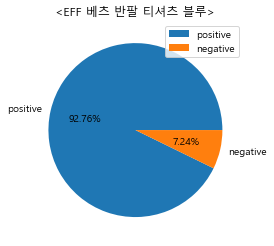

In [294]:
import matplotlib.pyplot as plt
labels=['positive', 'negative']

title = '<%s>' %(result_name)
plt.pie(ratio_list,labels=labels,autopct='%.2f%%')
plt.legend(labels)
plt.title(title)
plt.show()

In [300]:
#빈출 단어에서 제외되어야 할 단어
exception_list=[category_name, detail_category_name, brand_name]
#print(exception_list)

temp=mecab.nouns(brand_name)
exception_list=exception_list+temp
#print(exception_list)

temp=mecab.nouns(category_name)
exception_list=exception_list+temp
#print(exception_list)

temp=mecab.nouns(detail_category_name)
exception_list=exception_list+temp
#print(exception_list)

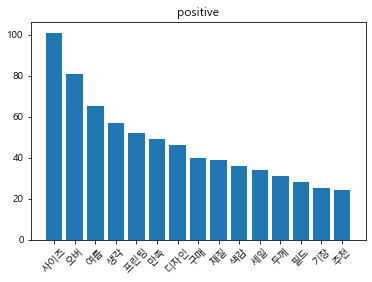

In [299]:
# positive_data 를 한 배열에 모두 넣고 명사로 분리
text4 = []
text5 = []
nm=[]

# 형태소로 분리되어 리스트로 구분되어 저장되어 있는 것을 하나의 문자열로 저장
for i in range (len(positive_data)):
    text3 = ' '.join(positive_data[i])
    text4.append(text3)
text5 = ' '.join(text4)

# 저장된 문자열을 명사로 분리
nm = mecab.nouns(text5)

#제외 단어를 리스트에서 삭제
for i in nm:
    if i in exception_list:
            nm.remove(i)

# Counter 명령어를 이용하여 문자당 사용된 빈도수를 계산
counter2 = Counter(nm)
available_counter2 = Counter({x: counter2[x] for x in counter2 if len(x) > 1})# 1글자 이하의 문자 제거
available_counter2.most_common(10)# 최다빈도 문자를 10개 출력
pos_real_avail=available_counter2.most_common(15)# 15개의 최다빈도 문자를 저장
#print(pos_real_avail)




positive_most_word=[]
positive_most_value=[]

#map을 이용하여 list에 묶여있는 데이터를 분리
real_avail=list(map(list,pos_real_avail))

#  word과 value를 따로 저장
for i in real_avail:
    positive_most_word.append(i[0])
    positive_most_value.append(i[1])

#print(positive_most_word)
#print(positive_most_value)




x1 = np.arange(len(positive_most_word))
plt.bar(x1, positive_most_value)
plt.title('positive')
plt.xticks(x1, positive_most_word)
plt.xticks(rotation=45)
plt.show()

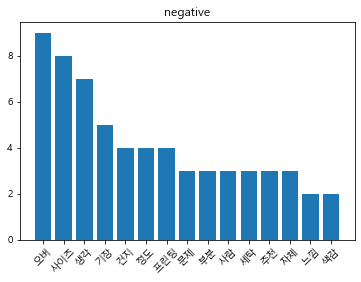

In [298]:
# negative_data 를 한 배열에 모두 넣고 명사로 분리
text7 = []
text8 = []
bl=[]
# 형태소로 분리되어 리스트로 구분되어 저장되어 있는 것을 하나의 문자열로 저장
for i in range (len(negative_data)):
    text6 = ' '.join(negative_data[i])
    text7.append(text6)
text8 = ' '.join(text7)
print("")

 # 저장된 문자열을 명사로 분리 
nl = mecab.nouns(text8)

#제외 단어를 리스트에서 삭제
for i in nl:
    if i in exception_list:
            nl.remove(i)

            # Counter 명령어를 이용하여 문자당 사용된 빈도수를 계산
counter1 = Counter(nl)

# 1글자 제거
available_counter1 = Counter({x: counter1[x] for x in counter1 if len(x) > 1})# 1글자 이하의 문자 제거
available_counter1.most_common(10)# 최다빈도 문자를 10개 출력
neg_real_avail=available_counter1.most_common(15)# 15개의 최다빈도 문자를 저장
#print(neg_real_avail)

negative_most_word=[]
negative_most_value=[]

#map을 이용하여 list에 묶여있는 데이터를 분리
real_avail=list(map(list,neg_real_avail))

#  word과 value를 따로 저장
for i in real_avail:
    negative_most_word.append(i[0])
    negative_most_value.append(i[1])

#print(negative_most_word)
#print(negative_most_value)

x2 = np.arange(len(negative_most_word))
plt.title('negative')
plt.bar(x2, negative_most_value)
plt.xticks(x2, negative_most_word)
plt.xticks(rotation=45)
plt.show()